<a href="https://colab.research.google.com/github/snxly/colab/blob/master/my_bigram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# get file
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-08-03 02:09:38--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  1.36MB/s    in 0.2s    

2025-08-03 02:09:38 (1.36 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [ ]:
# get words
words = open('names.txt', 'r').read().splitlines()
# size of words
len(words)

32033

In [ ]:
# I need utils i2s and s2i
chs = sorted(list(set("".join(words))))
s2i = {s:i+1 for i,s in enumerate(chs)}
s2i['.'] = 0
i2s = {i:s for s,i in s2i.items()}

# Create model by counting

In [ ]:
# init a tensor to save the count
import torch
vocab_size = len(s2i)
counts = torch.zeros((vocab_size, vocab_size), dtype=torch.int32)
counts.shape

torch.Size([27, 27])

In [ ]:
# get demo tuple
for w in words:
  chs = '.' + w + '.'
  for ch1, ch2 in zip(chs, chs[1:]):
    counts[s2i[ch1], s2i[ch2]] += 1

# counts

In [ ]:
# visualize counts
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
plt.imshow(counts, cmap='Blues')
for i in range(vocab_size):
    for j in range(vocab_size):
        chstr = i2s[i] + i2s[j]
        plt.text(j, i, chstr, ha="center", va="top", color='gray')
        plt.text(j, i, counts[i, j].item(), ha="center", va="bottom", color='gray')
plt.show()

## Sample


In [ ]:
# 1. turn counts to probs
probs = (counts+1).float()
probs /= probs.sum(1, keepdim=True)
probs[0], probs[0].sum()

(tensor([3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
         1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
         4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
         5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
         4.2109e-03, 1.6719e-02, 2.9008e-02]),
 tensor(1.))

In [ ]:
# 2. sample with the probs
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
  out = []
  ix = 0
  while True:
    p = probs[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(i2s[ix])
    if ix == 0:
      break
  print(''.join(out))


junide.
janasah.
p.
cony.
a.


## Evaluate


In [ ]:
# from probs to negative log likelihood
n = 0
total = 0
for w in words:
  chs = '.' + w + '.'
  for ch1, ch2 in zip(chs, chs[1:]):
    prob = probs[s2i[ch1], s2i[ch2]]
    total += -torch.log(prob)
    n += 1
nll = total/n
nll

tensor(2.4544)

# Create model by ML

In [ ]:
# 1. setup training set
xs, ys = [], []
for w in words[:1]:
  chs = '.' + w + '.'
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = s2i[ch1]
    ix2 = s2i[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)
print(xs, ys)

number of examples:  5
tensor([ 0,  5, 13, 13,  1]) tensor([ 5, 13, 13,  1,  0])


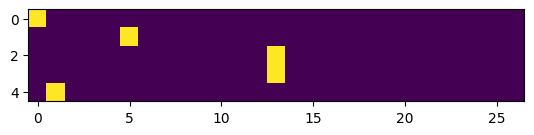

In [ ]:
# 2. init weights
W = torch.randn((vocab_size, vocab_size), requires_grad=True)
# 3. encode x
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=vocab_size).float()
plt.imshow(xenc)

In [ ]:
# forward pass
logits = xenc @ W
# loss
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(num), ys].log().mean()
print(loss)

tensor(3.4108, grad_fn=<NegBackward0>)


In [ ]:
# backward pass
W.grad = None
loss.backward()
# update data
W.data += -0.1 * W.grad

## Setup
1. setup training data
2. init weights

In [ ]:
# all in one
# 1. setup training set
xs, ys = [], []
for w in words:
  chs = '.' + w + '.'
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = s2i[ch1]
    ix2 = s2i[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
# 2. init weights
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((vocab_size, vocab_size), generator=g, requires_grad=True)

## Train the model

In [ ]:
for k in range(100):
  # encode input to one-hot
  xenc = F.one_hot(xs, num_classes=vocab_size).float()
  # forward pass
  logits = xenc @ W
  # loss = average negative log likelihood
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(num), ys].log().mean() + 0.0
  print('loss = ', loss)
  # backward pass
  W.grad = None
  loss.backward()
  # update data
  W.data += -1 * W.grad

## Sample

In [ ]:
for i in range(5):
  out = []
  idx = 0
  while True:
    # get probs with forward pass
    xenc = F.one_hot(torch.tensor([idx]), num_classes=vocab_size).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(i2s[idx])
    if idx == 0:
      break
  print(''.join(out))

morvann.
akela.
az.
arileri.
chaiadayrausbalodouseyton.


# 教训
1. 变量名不要和预留名字重复，比如 len
2. 第一次nll算出来了两倍的值，原因是统计了二维数组里的所有概率，导致每个概率都统计了两遍。正确的做法是，统计每一种可能的两位字符的概率。